# ASL Alphabet Classification with Deep Learning

AI and machine learning have become popular tools for language translation. In fact, The original Transformer architecture outlined in the Attention is All You Need paper targets the use case of language to language translation. While Transformer models have gone on to achieve much more than language translateion, they have made huge improvements for language tranalation applications.

Similarly, machine learning based image classification could be used to assist with with translation of sign language. According to the Rhode Island Commission on the Deaf and Hard of Hearing, roughly half a million Americans use Americal Sign Language (ASL) as their native language, making it the third most common language in the US, behind English and Spanish. While ASL is the most common signed language in the United States, there are around 300 total signed languages in use globally. 

Translation of ASL and other signed languages is important to foster inclusivity to those who utilize it as a native language, often those who are deaf or hard of hearing. Unlike other translation of other languages, which would deal with text or audio data, signed language poses a different challenge as it is a visual medium. This project utilizes Convolutional Neural Networks (CNNs) as an approach for classifying images of the ASL alphabet. While this project is limited to the ASL alphabet rather than a full translation, it serves as a proof of concept for how a similar approach could be utilized to create more robust sign language translation applications.

Source: https://cdhh.ri.gov/information-referral/american-sign-language.php#section2

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Data

This project uses an ASL Alphabet dataset found on Kaggle: https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data

The dataset contains images of each letter in the ASL alphabet. The data has been seperated into 29 different files, one for images of each of the 26 letters, and an additional file each for "space", "delete", or "nothing".

In [2]:
TEST_PATH = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

TRAIN_PATH = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

We can first create a function to load in the data from our path. This will return our images, a corresponding list of labels for each image, and also a list of all the letters that we have data for.

In [3]:
def load_data(path):

    dir_list = os.listdir(path)
    images = []
    labels = []
    letters = []

    for dir in dir_list:
        letter_imgs = os.listdir(os.path.join(path, dir))
        for img in letter_imgs:
            img_path = os.path.join(path, dir, img)
            image = cv2.imread(img_path)
            image =cv2.resize(image, (64,64))
            images.append(image)
            labels.append(dir)
        letters.append(dir)
    
    return images, labels, letters

In [4]:
images, labels, letters = load_data(TRAIN_PATH)

In [5]:
len(images)

87000

In [6]:
len(labels)

87000

In [7]:
print(letters)

['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']


## Exploring the Data

Before we begin modeling, we will quickly view the data to see what we are working with. To do this, we will display one image from each letter.

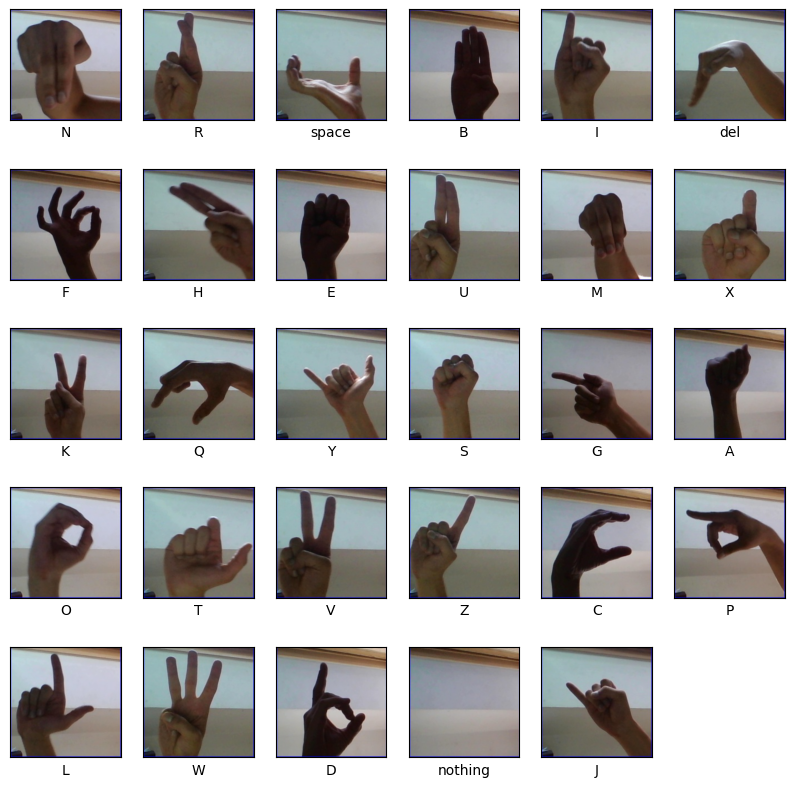

In [8]:
fig = plt.figure(figsize = (10,10))

for i in range(0,29):
    plt.subplot(5, 6, i+1)
    path = TRAIN_PATH + "/{letter}/{letter}1.jpg".format(letter = letters[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(letters[i])


## Data Preprocessing

To get our data ready for modeling we need to do a bit of pre-processing so that they will work with our model. We will first store our images as an np array and normalize their pixel values by dividing by 255.

In [9]:
images = np.array(images)
images = images.astype(float) / 255

Currently, our labels are character values for each letter in the alphabet. For training purposes, we want to encode these as numberic values.

In [10]:
labels_dict = {c: i for i, c in enumerate(set(labels))}
labels_nums = [labels_dict[c] for c in labels]
labels_encoded = to_categorical(labels_nums)

Finally we will split the data up into training and validation sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size = .2)

## CNN Model

Our image classification task wil utilize a Convolutional Neural Network (CNN). We will build this below by adding basic Conv2D layers with MaxPooling and Dropout layers in between. Finally, we will flatten the data and finalize the classification with dense layers. Our model will take in images of shape (64, 64, 3), which is what we re-sized the images to, and output a shape of 29, corresponding to our 26 letters and 3 additional characters.

In [12]:
model = Sequential()

model.add(Conv2D(filters = 64, input_shape = (64,64,3),  kernel_size = 3, strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 256, kernel_size = 3, strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(29, activation = 'softmax'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy','precision','recall'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,104,797 (19.47 MB)

 Trainable params: 5,104,797 (19.47 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [15]:
batch = 32

In [16]:
cb_list = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [17]:
history = model.fit(x = X_train, y = y_train, epochs = 100,batch_size = batch, validation_data = (X_test, y_test), callbacks = [cb_list] )

Epoch 1/100


I0000 00:00:1731461776.150864     430 service.cc:145] XLA service 0x7d6a5800d990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731461776.150923     430 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  24/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.0463 - loss: 3.4650 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1731461783.402289     430 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.5061 - loss: 1.6612 - precision: 0.7929 - recall: 0.4130 - val_accuracy: 0.9718 - val_loss: 0.0939 - val_precision: 0.9800 - val_recall: 0.9616
Epoch 2/100
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9461 - loss: 0.1567 - precision: 0.9569 - recall: 0.9373 - val_accuracy: 0.9920 - val_loss: 0.0251 - val_precision: 0.9932 - val_recall: 0.9907
Epoch 3/100
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9685 - loss: 0.0975 - precision: 0.9720 - recall: 0.9655 - val_accuracy: 0.9956 - val_loss: 0.0148 - val_precision: 0.9961 - val_recall: 0.9952
Epoch 4/100
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9766 - loss: 0.0738 - precision: 0.9788 - recall: 0.9746 - val_accuracy: 0.9971 - val_loss: 0.0099 - val_precision: 0.9972 - val_recall: 0.9970
Epoch 5/100
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9792 - loss: 0.0668 - precision: 0.9807 - recall: 0.9778 - val_accuracy: 0.9957 - val_

Our model appears to be performing well with a training accuracy of 0.9874 and a validation accuracy of 0.9968, which stopped the training after 12 epochs.

## Model Evaluation

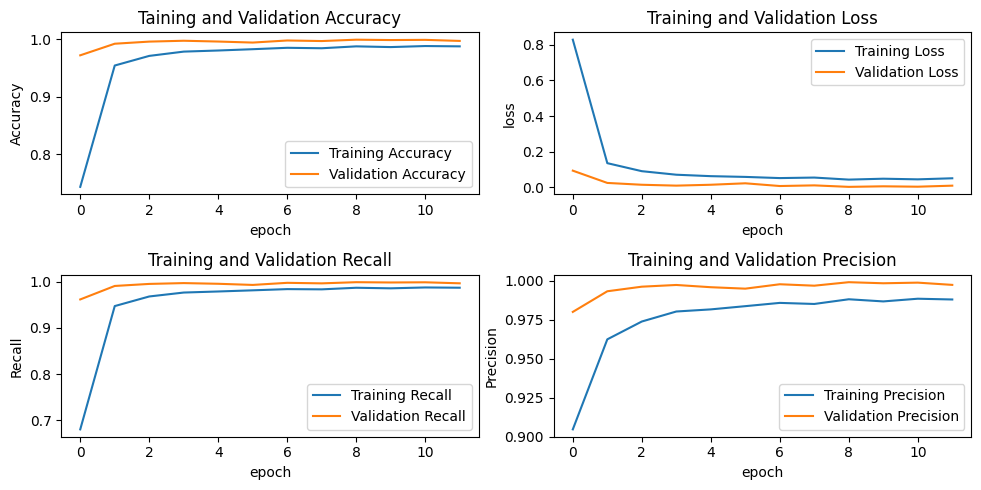

In [18]:
fig, ax = plt.subplots(2,2, figsize = (10,5))
ax[0,0].plot(history.history['accuracy'], label = 'Training Accuracy')
ax[0,0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax[0,0].set_title('Taining and Validation Accuracy')
ax[0,0].set_xlabel('epoch')
ax[0,0].set_ylabel('Accuracy')
ax[0,0].legend()

ax[0,1].plot(history.history['loss'], label = 'Training Loss')
ax[0,1].plot(history.history['val_loss'], label = 'Validation Loss')
ax[0,1].set_title('Training and Validation Loss')
ax[0,1].set_xlabel('epoch')
ax[0,1].set_ylabel('loss')
ax[0,1].legend()

ax[1,0].plot(history.history['recall'], label = 'Training Recall')
ax[1,0].plot(history.history['val_recall'], label = 'Validation Recall')
ax[1,0].set_title('Training and Validation Recall')
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('Recall')
ax[1,0].legend()

ax[1,1].plot(history.history['precision'], label = 'Training Precision')
ax[1,1].plot(history.history['val_precision'], label = 'Validation Precision')
ax[1,1].set_title('Training and Validation Precision')
ax[1,1].set_xlabel('epoch')
ax[1,1].set_ylabel('Precision')
ax[1,1].legend()

fig.tight_layout()
plt.show()

Our model appears to be classifying the images quite well based on all of the above metrics. From here we will take a sample of our validation data and visualize the images alongside our model's predictions.

In [19]:
class_map = {}
for c in labels_dict:
    num = labels_dict[c]
    class_map[num] = c

In [20]:
preds = model.predict(X_test)

preds = np.argmax(preds, axis = 1)

pred_letters = []
for pred in preds:
    letter = class_map[pred]
    pred_letters.append(letter)

544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


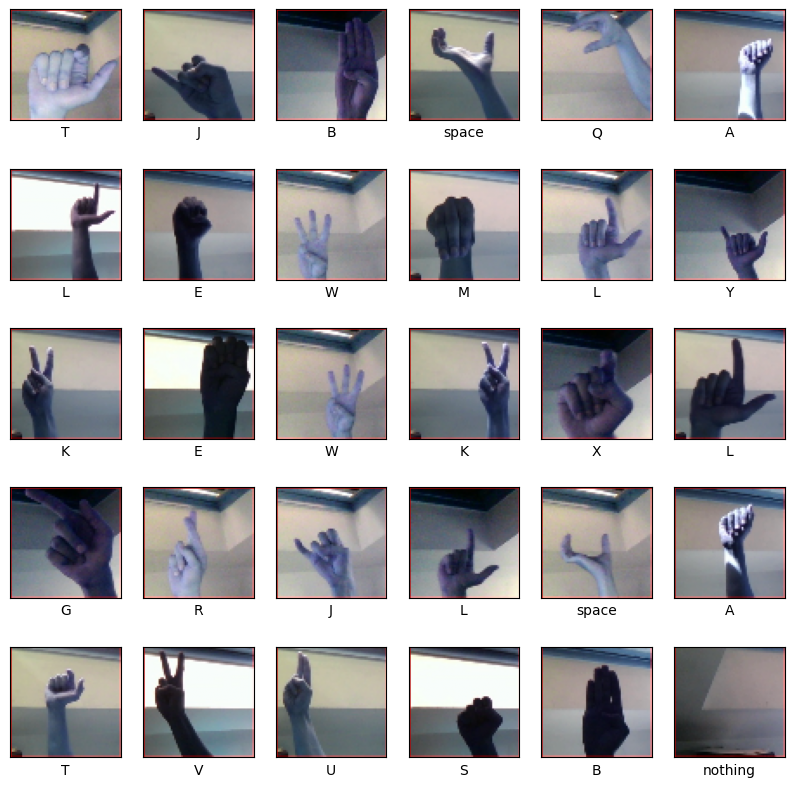

In [21]:



fig  = plt.figure(figsize= (10,10))
for i, img in enumerate( X_test[:30]):

    plt.subplot(5,6, i+1)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(pred_letters[i])
plt.show()



## Conclusion 

This project demonstrated utilizing a CNN to accurately classify letters in sign language. This acts as a basic proof of concept for sign language translation applications using deep learning and computer vision. While this project focused solely on still images of the sign language alphabet, future approaches could expand to a create a more robust translation application using an expanded vocabulary.

Such a translation application would likely require significantly more complexity. The application would need to support video data to capture movement, accomodate various background environments and motions, and understand context between words. 

This project, however, sets the stage for more ambitious development by showcasing a CNN model that can classify various images of the ASL alphabet with .99 accuracy.  